## All RBF Layers in one Class

In [16]:
import tensorflow as tf
import numpy as np
import gzip
import keras
import matplotlib.pyplot as plt
import time
import random
from sklearn.gaussian_process.kernels import PairwiseKernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam

In [17]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

# read data set
f = gzip.open('./data/train-images-idx3-ubyte.gz', 'rb')
x_train = np.array(np.frombuffer(f.read(), np.uint8, offset=16))

f = gzip.open('./data/train-labels-idx1-ubyte.gz', 'rb')
y_train = np.array(np.frombuffer(f.read(), np.uint8, offset=8))

f = gzip.open('./data/t10k-images-idx3-ubyte.gz', 'rb')
x_test = np.array(np.frombuffer(f.read(), np.uint8, offset=16))

f = gzip.open('./data/t10k-labels-idx1-ubyte.gz', 'rb')
y_test = np.array(np.frombuffer(f.read(), np.uint8, offset=8))

# data preprocessing
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255
x_train = x_train.astype(np.float32)
x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
x_test = x_test.astype(np.float32)

# get each training images
idx_train = [0 for i in range(10)]
idx_test = [0 for i in range(10)]
for i in range(10):
    idx_train[i] = (y_train == i)
    idx_test[i] = (y_test == i)
      
x_train_38 = x_train[idx_train[3]+idx_train[8]]
x_test_38 = x_test[idx_test[3]+idx_test[8]]


# one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

y_train_38 = y_train[idx_train[3]+idx_train[8]]
y_test_38 = y_test[idx_test[3]+idx_test[8]]

# y_temptr_38 = y_train[idx_train[3]+idx_train[8]][0:10000]
# y_tempte_38 = y_test[idx_test[3]+idx_test[8]][0:1500]


In [18]:
# K-Means clustering to find centers
centers = []
for i in range(10):
    kmeans_model = KMeans(10)
    kmeans_model.fit(x_train[idx_train[i]])
    centers.extend(kmeans_model.cluster_centers_)

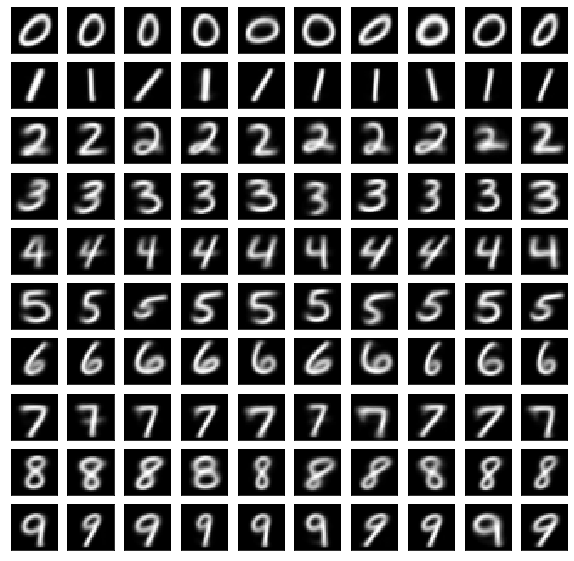

In [19]:
# plot cluster centers as images
fig = plt.figure(figsize = (10,10))

for i in range(100):
  subplot = fig.add_subplot(10, 10, i+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(np.reshape(centers[i]*255, (28, 28)), cmap='gray')
  

In [20]:
seg_num = 10

center_7x7 =[]
row_7x7 = [random.randrange(0,29-7) for _ in range(seg_num)]
col_7x7 = [random.randrange(0,29-7) for _ in range(seg_num)]

for i in range(seg_num):
    for center in centers:
        center_7x7.extend(center[r*28+col_7x7[i] : r*28+(col_7x7[i]+7)] 
                                for r in range(row_7x7[i],row_7x7[i]+7))

center_7x7 = np.reshape(center_7x7,(-1,7*7))
print(center_7x7.shape)

(1000, 49)


In [21]:
seg_num = 10
center_14x14 =[]
row_14x14 = [random.randrange(0,29-14) for _ in range(seg_num)]
col_14x14 = [random.randrange(0,29-14) for _ in range(seg_num)]

for i in range(seg_num):
    for center in centers:
        center_14x14.extend(center[r*28+col_14x14[i] : r*28+(col_14x14[i]+14)] 
                                for r in range(row_14x14[i],row_14x14[i]+14))

center_14x14 = np.reshape(center_14x14,(-1,14*14))
print(center_14x14.shape)

(1000, 196)


In [22]:
# center_28x28 = _38[:]
# center_28x28 = np.array(center_28x28)
# print(center_28x28.shape)

In [23]:
x_7 = np.zeros((len(centers),len(centers)))
for i in range(len(centers)):
    x_7[i][i] = 1

x_14 = np.zeros((len(centers),len(centers)))
for i in range(len(centers)):
    x_14[i][i] = 1

x_28 = np.zeros((len(centers),len(centers)))
for i in range(len(centers)):
    x_28[i][i] = 1

In [24]:
trimg_7x7 = []
trlab_7x7 = []
testimg_7x7 = []
testlab_7x7 = []

for i in range(seg_num):
    
    for arr in x_train:
        trimg_7x7.extend(arr[r*28+col_7x7[i] : r*28+(col_7x7[i]+7)]
                         for r in range(row_7x7[i],row_7x7[i]+7))
        
    for arr in x_test:
        testimg_7x7.extend(arr[r*28+col_7x7[i] : r*28+(col_7x7[i]+7) ] 
                                  for r in range(row_7x7[i],row_7x7[i]+7))   
    
    for arr in y_train:    
        trlab_7x7.extend(arr)

    for arr in y_test:    
        testlab_7x7.extend(arr)

trimg_7x7 = np.reshape(trimg_7x7,(-1,7*7))  
testimg_7x7 = np.reshape(testimg_7x7,(-1,7*7))    
trlab_7x7 = np.reshape(trlab_7x7,(-1,10))
testlab_7x7 = np.reshape(testlab_7x7,(-1,10))

print(trimg_7x7.shape)
print(testimg_7x7.shape)

(600000, 49)
(100000, 49)


In [25]:
trimg_14x14 = []
trlab_14x14 = []
testimg_14x14 = []
testlab_14x14 = []

for i in range(seg_num):
    for arr in x_train:
        trimg_14x14.extend(arr[r*28+col_14x14[i] : r*28+(col_14x14[i]+14) ] 
                                  for r in range(row_14x14[i],row_14x14[i]+14))
    for arr in x_test:
        testimg_14x14.extend(arr[r*28+col_14x14[i] : r*28+(col_14x14[i]+14)] 
                                  for r in range(row_14x14[i],row_14x14[i]+14))
    
    for arr in y_train:    
        trlab_14x14.extend(arr)

    for arr in y_test:    
        testlab_14x14.extend(arr)

trimg_14x14 = np.reshape(trimg_14x14,(-1,14*14))
testimg_14x14 = np.reshape(testimg_14x14,(-1,14*14))
trlab_14x14 = np.reshape(trlab_14x14,(-1,10))
testlab_14x14 = np.reshape(testlab_14x14,(-1,10))

print(trimg_14x14.shape)
print(testimg_14x14.shape)

(600000, 196)
(100000, 196)


In [26]:
trimg_28x28 = []
trlab_28x28 = []
testimg_28x28 = []
testlab_28x28 = []

for i in range(10):
    for arr in x_train:
        trimg_28x28.extend(arr)
    for arr in x_test:
        testimg_28x28.extend(arr)
    for arr in y_train:    
        trlab_28x28.extend(arr)
    for arr in y_test:    
        testlab_28x28.extend(arr)

trimg_28x28 = np.reshape(trimg_28x28,(-1,28*28))  
testimg_28x28 = np.reshape(testimg_28x28,(-1,28*28))
trlab_28x28 = np.reshape(trlab_28x28,(-1,10))
testlab_28x28 = np.reshape(testlab_28x28,(-1,10))

print(trimg_28x28.shape)
print(testimg_28x28.shape)


(600000, 784)
(100000, 784)


In [27]:
# black1 = []
# black2 =[]
# for i in range(100):
#     black1.append(center_7x7[1])
#     black2.append(center_14x14[1])

In [28]:

kernel = PairwiseKernel(metric='polynomial') 
rbf_models = GaussianProcessRegressor(kernel=kernel,alpha=0.1).fit(center_7x7[0:len(centers)], x_7)

temp1= (rbf_models.predict(trimg_7x7[0:len(x_train)]))
temp2= (rbf_models.predict(testimg_7x7[0:len(x_test)]))
print(temp1.shape)

for i in range(1,seg_num):
    rbf_models = GaussianProcessRegressor(kernel=kernel,alpha=0.1).fit(center_7x7[len(centers)*i:len(centers)*(i+1)], x_7)

    temp1= np.hstack([temp1,(rbf_models.predict(trimg_7x7[len(x_train)*i:len(x_train)*(i+1)]))])
    temp2= np.hstack([temp2,(rbf_models.predict(testimg_7x7[len(x_test)*i:len(x_test)*(i+1)]))])

for i in range(seg_num):
    rbf_models = GaussianProcessRegressor(kernel=kernel,alpha=0.1).fit(center_14x14[len(centers)*i:len(centers)*(i+1)], x_14)

    temp1= np.hstack([temp1,(rbf_models.predict(trimg_14x14[len(x_train)*i:len(x_train)*(i+1)]))])
    temp2= np.hstack([temp2,(rbf_models.predict(testimg_14x14[len(x_test)*i:len(x_test)*(i+1)]))])

    
# 29x28 이미지 포함, (Input 420으로 변경)

# rbf_models = GaussianProcessRegressor(kernel=kernel,alpha=0.1).fit(center_28x28[0:20], x_28)
# temp1= np.hstack([temp1,(rbf_models.predict(trimg_28x28[0:len(x_train_38)]))])
# temp2= np.hstack([temp2,(rbf_models.predict(testimg_28x28[0:len(x_test_38)]))])

print(temp1.shape)
print(temp2.shape)


(60000, 100)
(60000, 2000)
(10000, 2000)


In [29]:

batch_size = 128
epochs = 100

model = Sequential()
model.add(Dense(10, activation='softmax', input_shape=(2000,)))


model.summary()
nadam=keras.optimizers.Nadam(lr=0.0003)
model.compile(loss='categorical_crossentropy',optimizer=nadam,metrics=['accuracy'])

history = model.fit(temp1,y_train
                         ,batch_size=batch_size
                         ,epochs=epochs
                         ,verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                20010     
Total params: 20,010
Trainable params: 20,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
60000/60000 [==============================] - 3s 43us/step - loss: 1.1179 - acc: 0.7135
Epoch 2/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.4040 - acc: 0.9270
Epoch 3/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.2721 - acc: 0.9478
Epoch 4/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.2134 - acc: 0.9576
Epoch 5/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.1786 - acc: 0.9635
Epoch 6/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.1551 - acc: 0.9674
Epoch 7/100
60000/60000 [==============================] - 1

60000/60000 [==============================] - 1s 24us/step - loss: 0.0154 - acc: 0.9985
Epoch 77/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.0151 - acc: 0.9986
Epoch 78/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.0148 - acc: 0.9987
Epoch 79/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.0146 - acc: 0.9987
Epoch 80/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.0143 - acc: 0.9987
Epoch 81/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.0140 - acc: 0.9989
Epoch 82/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.0138 - acc: 0.9988
Epoch 83/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.0135 - acc: 0.9989
Epoch 84/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.0133 - acc: 0.9990
Epoch 85/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.0130 - acc: 

In [30]:
score = model.evaluate(temp2,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10503253134555197
Test accuracy: 0.9748
